In [153]:
import os
import numpy as np
import pandas as pd
from numba import jit, njit
from scipy.optimize import curve_fit
from scipy.io import loadmat
from scipy.stats import linregress
from scipy.stats import pearsonr
from scipy.signal import convolve
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import seaborn as sns
from spattemp.functions import *
from tqdm.notebook import tqdm

rng = np.random.default_rng()
plt.style.use("default")
sns.set(context="notebook")

In [155]:
def sc_model(
        running_stimuli,
        frozen_stimuli,
        running_responses,
        frozen_responses,
        stas,
        kernel_size,
        sta_window,
        fit_func,
        fit_bounds=(-np.inf, np.inf),
        fit_bins=80,
):
    total_cells = running_responses.shape[0]
    output_dict = {
        "cell_id": [],
        "w": [],
        "ln_fit_params": [],
        "r_value": [],
        "gauss_fit_params": [],
    }

    x = np.arange(0, sta_window * 2)
    y = np.arange(0, sta_window * 2)
    xx, yy = np.meshgrid(x, y)
    xdata = np.vstack((xx.ravel(), yy.ravel()))
    initial_guesses = (1., sta_window, sta_window, *5*np.eye(2).ravel())

    for cell_id in tqdm(range(total_cells), desc="Cell"):
        response_to_running = running_responses[cell_id]

        cell_sta = stas[cell_id]
        cell_mis_pos = get_mis_pos(cell_sta)
        mis_t, mis_y, mis_x = cell_mis_pos

        spatial_kernel, temporal_kernel = get_spat_temp_kern(cell_sta, cell_mis_pos, sta_window)

        kern_to_fit = spatial_kernel.ravel()
        gaussian_params, _ = curve_fit(gauss_2d, xdata, kern_to_fit, p0=initial_guesses)

        fitted_gaussian = gauss_2d(xdata, *gaussian_params)

        running_i_mean, running_lsc = convolve_stimulus_with_kernels_for_sc(
            stimulus=running_stimuli,
            spatial_kernel=fitted_gaussian,
            temporal_kernel=temporal_kernel,
            total_trials=running_responses.shape[1],
            sta_x=mis_x,
            sta_y=mis_y,
            sta_window=sta_window,
        )

        chosen_w, chosen_params = fit_parameters(
            convolved_a=running_i_mean,
            convolved_b=running_lsc,
            nbins=fit_bins,
            response=response_to_running,
            kernel_size=kernel_size,
            fit_func=fit_func,
            init_ws=(-50, 51, 10),
            p0=(4.0, 0.0, -0.001),
            fit_bounds=fit_bounds,
            passes=3,
            plot=False
        )

        response_to_frozen = frozen_responses[cell_id]

        frozen_i_mean, frozen_lsc = convolve_stimulus_with_kernels_for_sc(
            stimulus=frozen_stimuli,
            spatial_kernel=fitted_gaussian,
            temporal_kernel=temporal_kernel,
            total_trials=1,
            sta_x=mis_x,
            sta_y=mis_y,
            sta_window=sta_window,
        )

        convolved_signal = frozen_i_mean[0] + chosen_w * frozen_lsc[0]

        fitted_nonlinearity = fit_func(convolved_signal, *chosen_params)

        ground_truth = np.mean(response_to_frozen, axis=0)[kernel_size - 1:]

        r_value, p_value = pearsonr(ground_truth, fitted_nonlinearity)

        output_dict["cell_id"].append(cell_id)
        output_dict["w"].append(chosen_w)
        output_dict["ln_fit_params"].append(chosen_params)
        output_dict["r_value"].append(r_value)
        output_dict["gauss_fit_params"].append(gaussian_params)

    return output_dict

@jit
def gauss_2d(x, a, mu1, mu2, s11, s12, s21, s22):
    results = np.zeros(x.shape[1])

    sigma = np.array([[s11, s12], [s21, s22]])
    sigma_inv = np.linalg.inv(sigma)
    s11_, s12_, s21_, s22_ = sigma_inv[0, 0], sigma_inv[0, 1], sigma_inv[1, 0], sigma_inv[1, 1]
    sigma_det = np.linalg.det(sigma)

    norm = a / (2 * np.pi * np.sqrt(sigma_det))

    for i, (x1, x2) in enumerate(x.T):
        exp = s11_ * (x1 - mu1) ** 2 + s22_ * (x2 - mu2) ** 2 + \
            (s12_ + s21_) * (x1 - mu1) * (x2 - mu2)
        results[i] = norm * np.exp(-exp / 2)

    return results


def convolve_stimulus_with_kernels_for_sc(stimulus, spatial_kernel, temporal_kernel, total_trials, sta_x, sta_y, sta_window):
    convolved_response_i_mean = np.zeros((total_trials, stimulus.shape[1] - temporal_kernel.size + 1))
    convolved_response_lsc = np.zeros((total_trials, stimulus.shape[1] - temporal_kernel.size + 1))

    for tr, trial in enumerate(stimulus[:total_trials]):
        # Cut sta around MIS
        trial = trial[:, sta_y - sta_window:sta_y + sta_window, sta_x - sta_window:sta_x + sta_window]
        # reshape trial to (X*Y, Time)
        trial = trial.reshape((trial.shape[0], trial.shape[1] * trial.shape[2]))
        # calculate temporal convolution
        temp_conv = convolve(trial, np.expand_dims(temporal_kernel, axis=-1), mode="valid")
        # calculate the I_mean and LSC according t0 Liu and Gollisch, Natural Image Coding
        inner_sum = spatial_kernel * temp_conv
        spat_conv = inner_sum.mean(axis=-1)  # I_mean
        loc_spat_conv = np.sqrt(((inner_sum - np.expand_dims(spat_conv, 1))**2).sum(axis=-1) / (spatial_kernel.size - 1))  # LSC
        convolved_response_i_mean[tr] = spat_conv
        convolved_response_lsc[tr] = loc_spat_conv
    return convolved_response_i_mean, convolved_response_lsc


def softmax_model(x, a1, a2, a3):
    return a1 * np.log(1 + np.exp(a2 * (x + a3)))


def get_avg_spk_cts_per_bin(convolved_signal, bins, response, kernel_size):
    convolved_bin_ids = np.digitize(convolved_signal, bins)

    avg_spk_cts_per_bin = np.zeros(bins.size)
    for b, cbin in enumerate(bins):
        bin_id_pos = np.where(convolved_bin_ids == b)
        num_bins = bin_id_pos[0].size
        if num_bins > 0:
            trial_pos, bin_pos = bin_id_pos
            bin_pos += kernel_size - 1
            avg_spk_cts_per_bin[b] = np.mean(response[trial_pos, bin_pos])

    return avg_spk_cts_per_bin


def _sc_model(param_dict, w, *fit_params):
    convolved_a, convolved_b = param_dict["imean"], param_dict["lsc"]
    nbins = param_dict["nbins"]
    response = param_dict["response"]
    kernel_size = param_dict["kernel_size"]

    convolved_signal = convolved_a + w * convolved_b

    bins = np.linspace(convolved_signal.min(), convolved_signal.max(), nbins)

    xs = (bins[1:] + bins[:-1])/2

    hist = get_avg_spk_cts_per_bin(convolved_signal, bins, response, kernel_size)



def fit_parameters(
        convolved_a,
        convolved_b,
        nbins,
        response,
        kernel_size,
        fit_func,
        init_ws,
        p0=(4.0, 1000.0, 0.0),
        fit_bounds=([0.0, 1000.0, -1.0], [20.0, 20000.0, 1.0]),
        passes=3,
        plot=True,
):
    pass_results = {"ws": [], "params": [], "rvalues": []}
    next_ws = np.arange(*init_ws)
    step = init_ws[-1]
    chosen_w = 0.0
    chosen_params = p0

    for p in range(passes):
        if plot:
            fig, axes = plt.subplots(ncols=len(next_ws) // 2, nrows=2, sharey=True, sharex=True, figsize=(20, 8))

        for i, w in enumerate(next_ws):
            # calculate convolved signal as a combination of i_mean and lsc signals
            convolved_signal = convolved_a + w * convolved_b

            # obtain binning for the calculated signal
            bins = np.linspace(convolved_signal.min(), convolved_signal.max(), nbins)

            # setup x values for the non-linearity histogram
            xs = (bins[1:] + bins[:-1])/2

            try:
                # obtain fitted params
                cs_size = convolved_signal.shape[-1]
                params, cov = curve_fit(fit_func, convolved_signal.ravel(), response[:, -cs_size:].ravel(), p0=chosen_params, bounds=fit_bounds)
            except RuntimeError:
                print(f"Least sq. optimization failed for w={w}... skipping it!")
                params = p0

            # obtain fit
            y_fit = fit_func(xs, *params)

            # calculate avergae spike counts per bin (y values of the non-linearity histogram)
            hist = get_avg_spk_cts_per_bin(convolved_signal, bins, response, kernel_size)

            # calculate error
            res = linregress(hist[1:], y_fit[:])

            try:
                if plot:
                    curr_axis = axes.flatten()[i]

                    curr_axis.plot(xs, hist[1:], marker='o', ms=5, c='tab:blue')
                     # plot the fitted curve
                    curr_axis.plot(xs, y_fit, ls="--", c="tab:red")
                    # rotate xaxis labels
                    curr_axis.tick_params(axis="x", rotation=45)
                    # set title for single axis
                    curr_axis.set_title(f"w: {w:.2f}, a1: {params[0]:.2f}, a2: {params[1]:.2f}, a3: {params[2]:.3f}")

                    curr_axis.text(0.02, 0.92, f"Corr. Coeff.: {res.rvalue:.5f}", transform=curr_axis.transAxes)
            except IndexError:
                continue

            pass_results["ws"].append(w)
            pass_results["params"].append(params)
            pass_results["rvalues"].append(res.rvalue)

        max_pos = np.argmax(pass_results["rvalues"])
        chosen_params = pass_results["params"][max_pos]
        chosen_w = pass_results["ws"][max_pos]
        step = step / 10.0
        next_ws = np.arange(chosen_w - 5 * step, chosen_w + 6 * step, step)

        pass_results = {"ws": [], "params": [], "rvalues": []}

        if plot:
            fig.suptitle(f"Pass {p+1}")
            plt.tight_layout()
            plt.show()

    return chosen_w, chosen_params


def get_base_decimal(number):
    """Returns a float with the same number of decimal places as the input.

    :param number: (float) Input number.
    :return:
        (float) Power of 10 containing as many decimals as input.
    """
    sci_not_num = np.format_float_scientific(number)
    exponent = int(sci_not_num.split("e")[-1])
    base_decimal = np.abs(10 ** exponent)
    return base_decimal


def save_all_gauss_fit_plots(sta_array, output_df, sta_window, save_folder):
    if not os.path.exists(save_folder):
        print("Folder does not exist! Creating it!")
        os.makedirs(save_folder, exist_ok=True)

    for idx, row in tqdm(output_df.iterrows(), total=len(output_df), desc="Cells"):
        cell_id = row["cell_id"]
        gauss_params = row["gauss_fit_params"]
        sta = sta_array[cell_id]
        spat_kern, _ = get_spat_temp_kern(sta, get_mis_pos(sta), sta_window)

        fig = plot_fitted_gauss2d(spat_kern, gauss_params, sta_window)
        fig.suptitle(f"Cell {cell_id}", y=0.85)
        plt.savefig(os.path.join(save_folder, f"GaussFit_Cell_{cell_id}.png"), bbox_inches='tight')
        plt.close()

In [3]:
stimuli_path = "./stimuli_npy"
stas_path = "./stas"
datasets_path = "./cell_data"

In [4]:
dataset = "cell_data_01_NC"
kernel_size = 25
sta_window = 25

In [5]:
stas = np.load(os.path.join(stas_path, dataset + f"_stas_{kernel_size}.npy"))

In [6]:
data = loadmat(os.path.join(datasets_path, dataset) + ".mat")
running, frozen = data["spk1"], data["spk2"]
running = np.transpose(running, (0, 2, 1))
frozen = np.transpose(frozen, (0, 2, 1))

In [7]:
stimuli = np.load(os.path.join(stimuli_path, "running_stimuli.npy"), mmap_mode="r")
frozen_stimuli = np.load(os.path.join(stimuli_path, "frozen_stimuli.npy"))
frozen_stimuli = np.expand_dims(frozen_stimuli, axis=0)

In [107]:
stimuli.mean()

-3.515259259259259e-06

-3.515259259259259e-06

In [8]:
print("(#cells, #bins, #height, #width)")
print(stas.shape)

(#cells, #bins, #height, #width)
(78, 25, 150, 200)


In [9]:
print("(#cells, #trials, #bins)")
print(running.shape)
print(frozen.shape)

(#cells, #trials, #bins)
(78, 219, 1500)
(78, 219, 300)


In [10]:
print("(#trials, #bins, #height, #width)")
print(stimuli.shape)

(#trials, #bins, #height, #width)
(300, 1500, 150, 200)


In [11]:
# calculate the spatial pos of the most interesting stixel for each sta
mis_pos_list = [get_mis_pos(cell) for cell in stas]

## Single Cell

In [12]:
cell_id = 63
cell_response = running[cell_id]

In [13]:
cell_sta = stas[cell_id]
cell_mis_pos = mis_pos_list[cell_id]

In [14]:
t_, y_, x_ = cell_mis_pos

In [15]:
spat_kern, temp_kern = get_spat_temp_kern(cell_sta, cell_mis_pos, sta_window)

### Setup Fit Params for 2D Gaussian Fit

In [16]:
def fit_gauss2d(spatial_kernel, sta_window):
    x = np.arange(0, sta_window * 2)
    y = np.arange(0, sta_window * 2)
    xx, yy = np.meshgrid(x, y)
    xdata = np.vstack((xx.ravel(), yy.ravel()))

    initial_guesses = (1., sta_window, sta_window, *5*np.eye(2).ravel())
    to_fit = spatial_kernel.ravel()

    # Do the fit!
    fit_params, _ = curve_fit(gauss_2d, xdata, to_fit, p0=initial_guesses)
    fitted_gaussian = gauss_2d(xdata, *fit_params)

    return fit_params, fitted_gaussian


def plot_fitted_gauss2d(spatial_kernel, fit_params, sta_window):
    x = np.arange(0, sta_window * 2)
    y = np.arange(0, sta_window * 2)
    xx, yy = np.meshgrid(x, y)
    xdata = np.vstack((xx.ravel(), yy.ravel()))

    fitted_gaussian = gauss_2d(xdata, *fit_params)

    original = spatial_kernel / np.linalg.norm(spatial_kernel)
    fitted = fitted_gaussian / np.linalg.norm(fitted_gaussian)

    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
    cmap = cm.get_cmap('inferno')
    normalizer = Normalize(min(original.min(), fitted.min()), max(original.max(), fitted.max()))
    ax[0].imshow(original.reshape(sta_window * 2, sta_window * 2), cmap=cmap, norm=normalizer)
    ax[0].set_title("Original")
    ax[1].imshow(fitted.reshape(sta_window * 2, sta_window * 2), cmap=cmap, norm=normalizer)
    ax[1].set_title("Gaussian Fit")

    for a in ax:
        a.grid(False)

    return fig

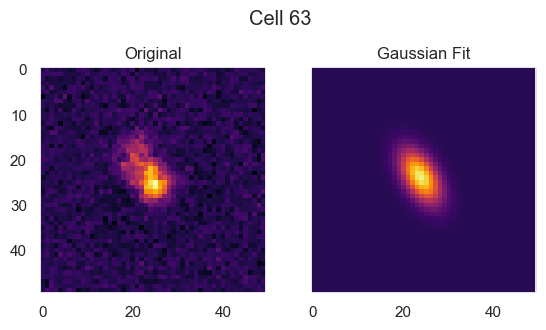

In [30]:
gauss_params, pred_spat_kern = fit_gauss2d(spat_kern, sta_window)
fig = plot_fitted_gauss2d(spat_kern, gauss_params, sta_window)
fig.suptitle(f"Cell {cell_id}", y=0.85)
plt.show()

In [83]:
pred_spat_kern.max() - pred_spat_kern.min()

0.14949749745658603

In [81]:
spat_kern.std()

0.019661872757174848

### Calculate $I_{mean}$ and Local Spatial Contrast

In [128]:
i_mean, lsc = convolve_stimulus_with_kernels_for_sc(stimuli, pred_spat_kern, temp_kern, running.shape[1], x_, y_, sta_window)

Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


In [131]:
print(i_mean.min(), i_mean.max())
print(lsc.min(), lsc.max())
print(i_mean.mean())
print(i_mean.std())

-0.0015673398496098463 0.0016124387656524881
0.012415538954672236 0.02485282704793498
-2.917058876135307e-07
0.00036762064274238013


In [132]:
bounds = ([0.0, 0.0, -1.0],
          [2000.0, 20000.0, 1.0])
num_bins = 80

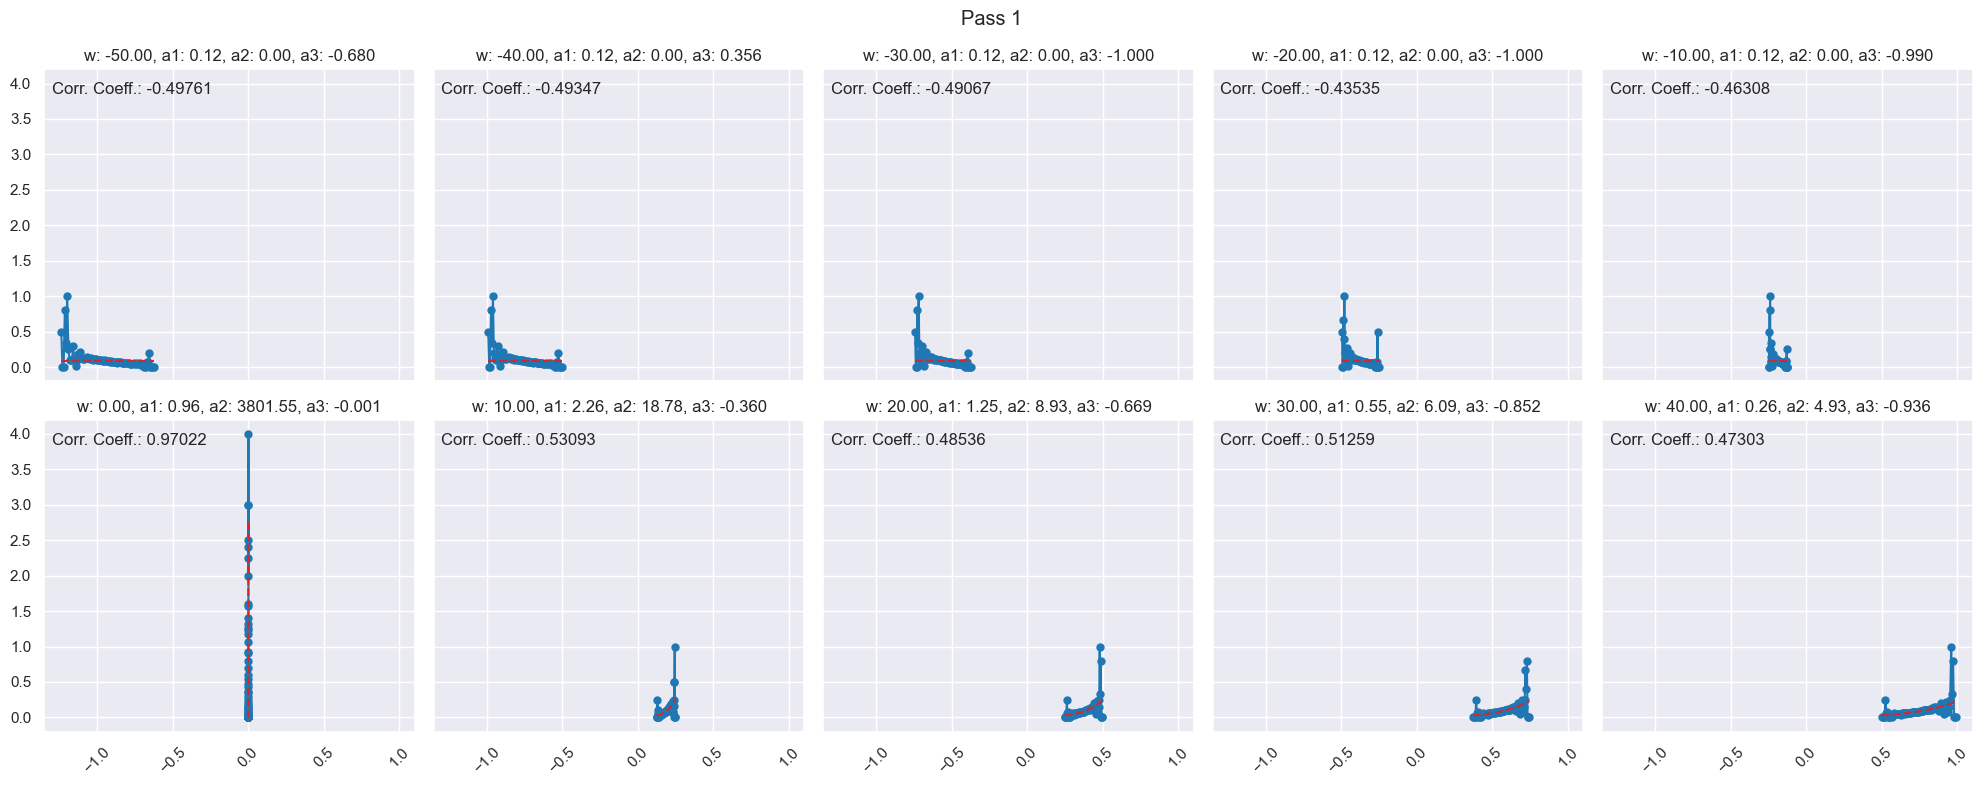

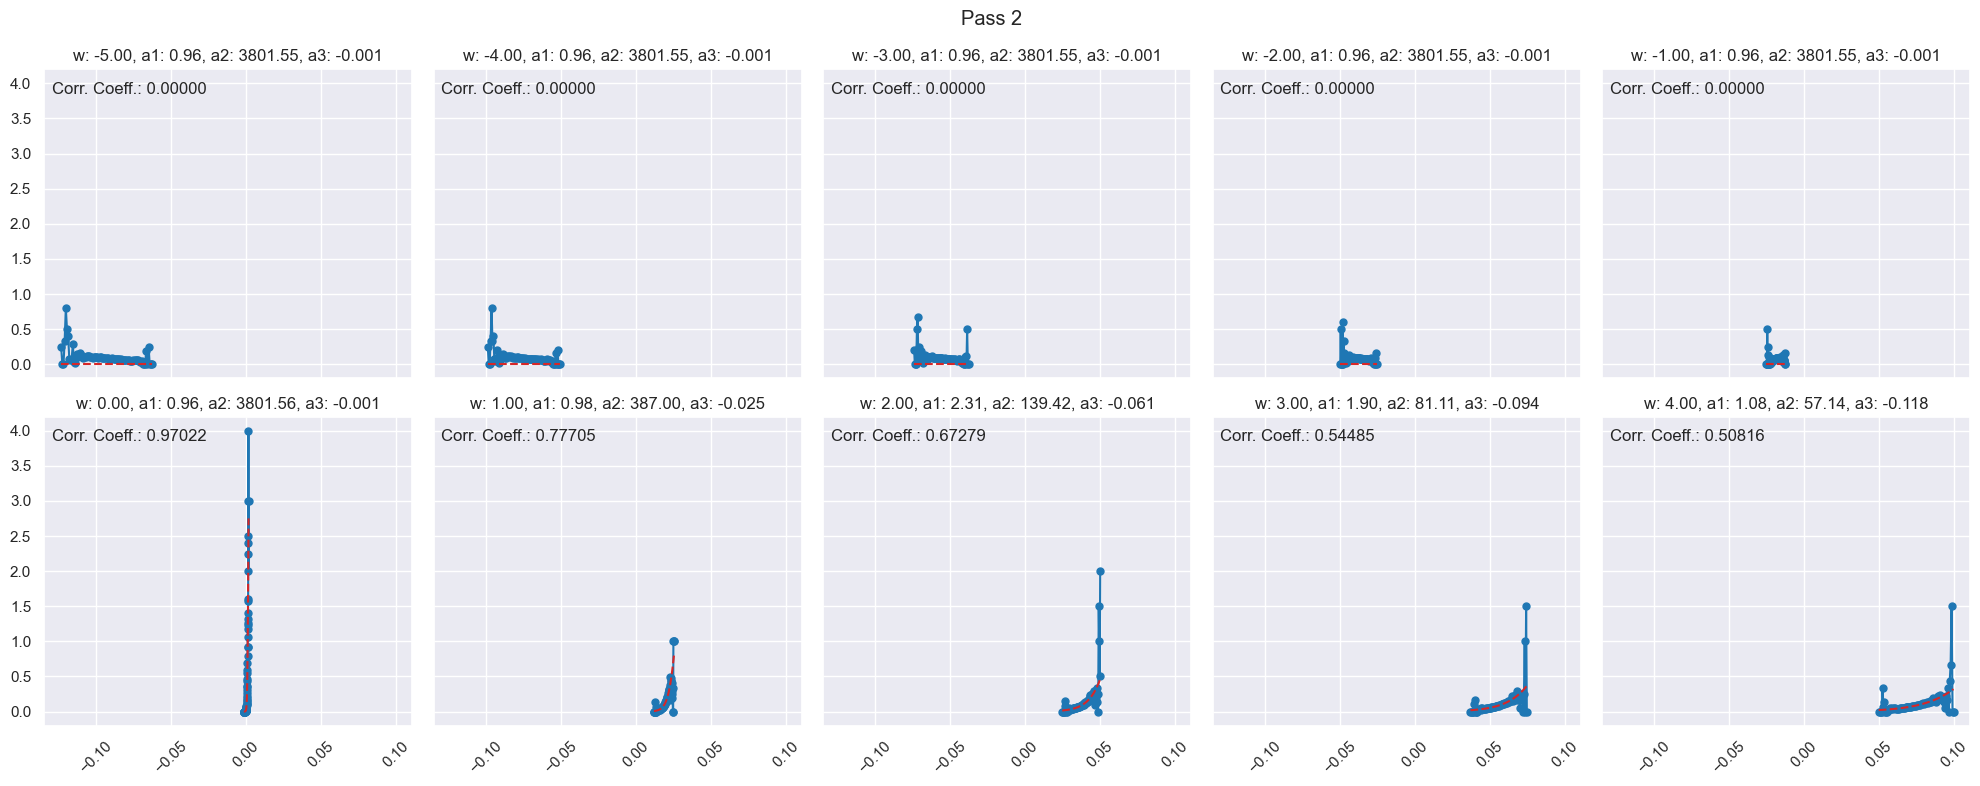

/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))
/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))
/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))
/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


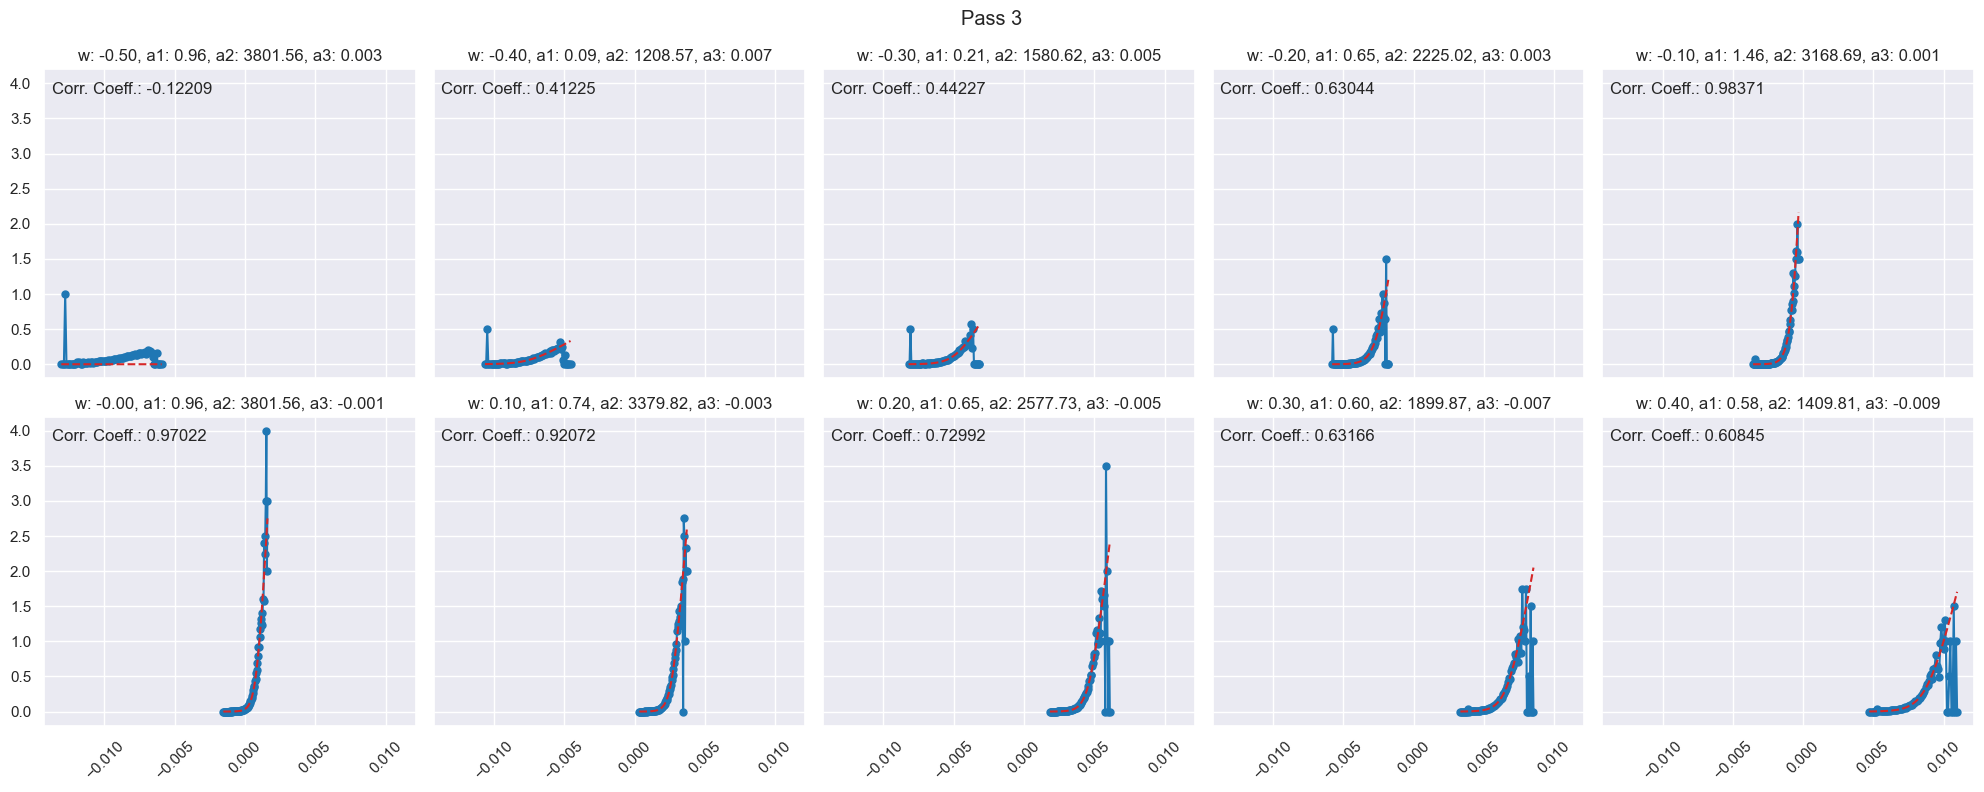

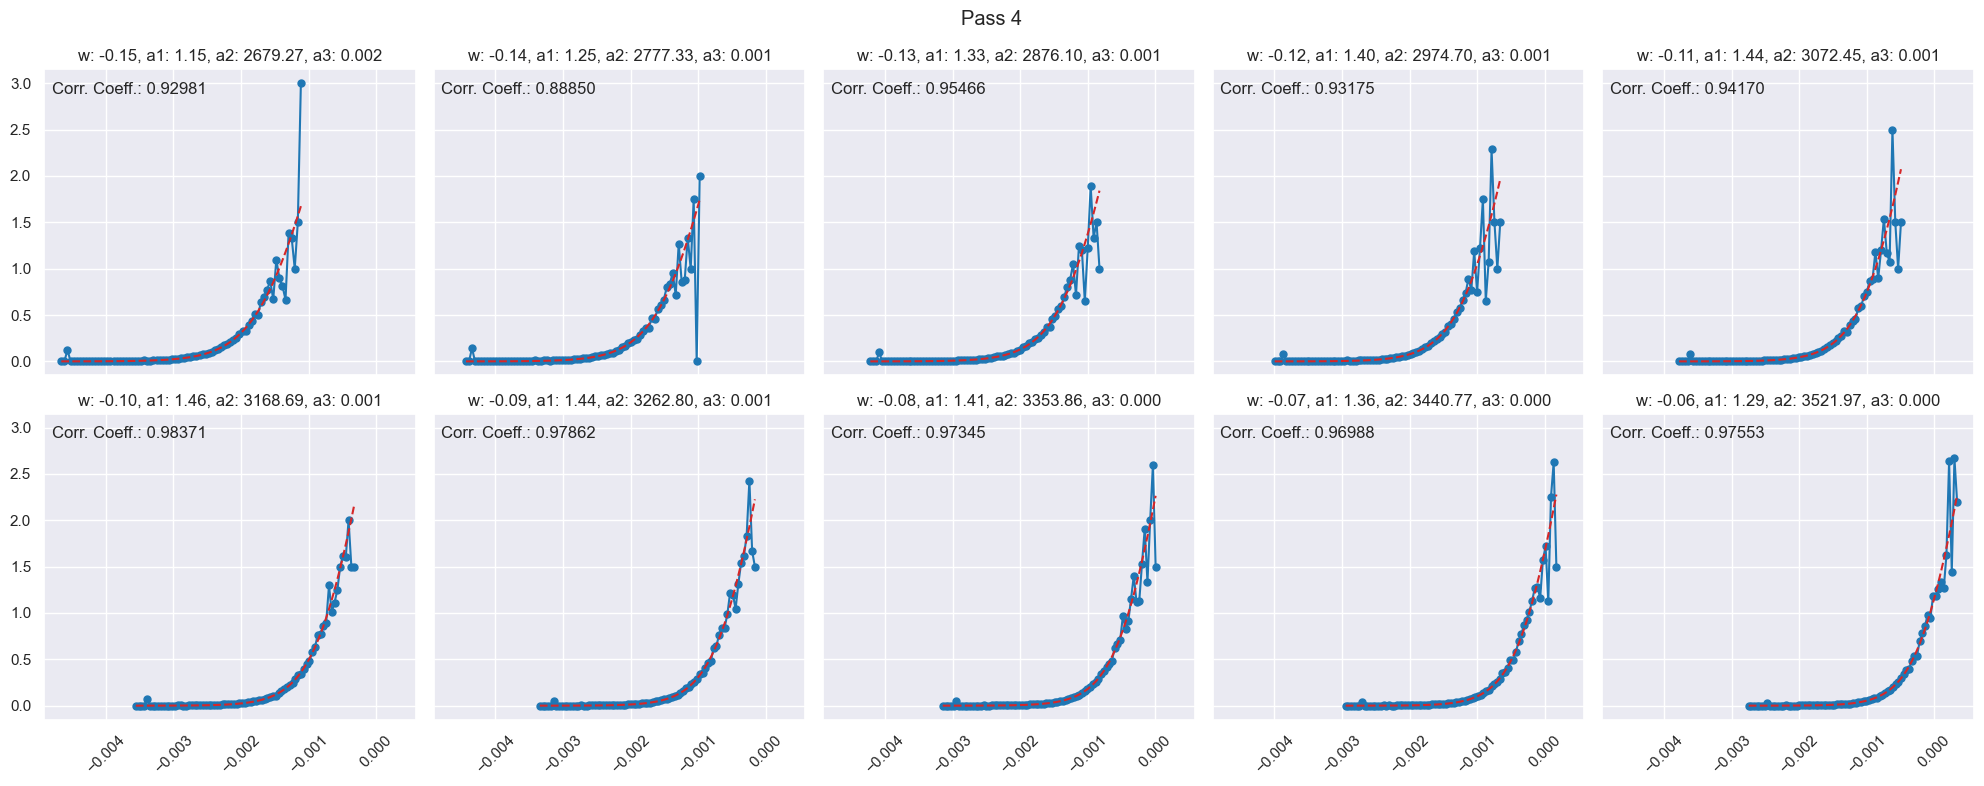

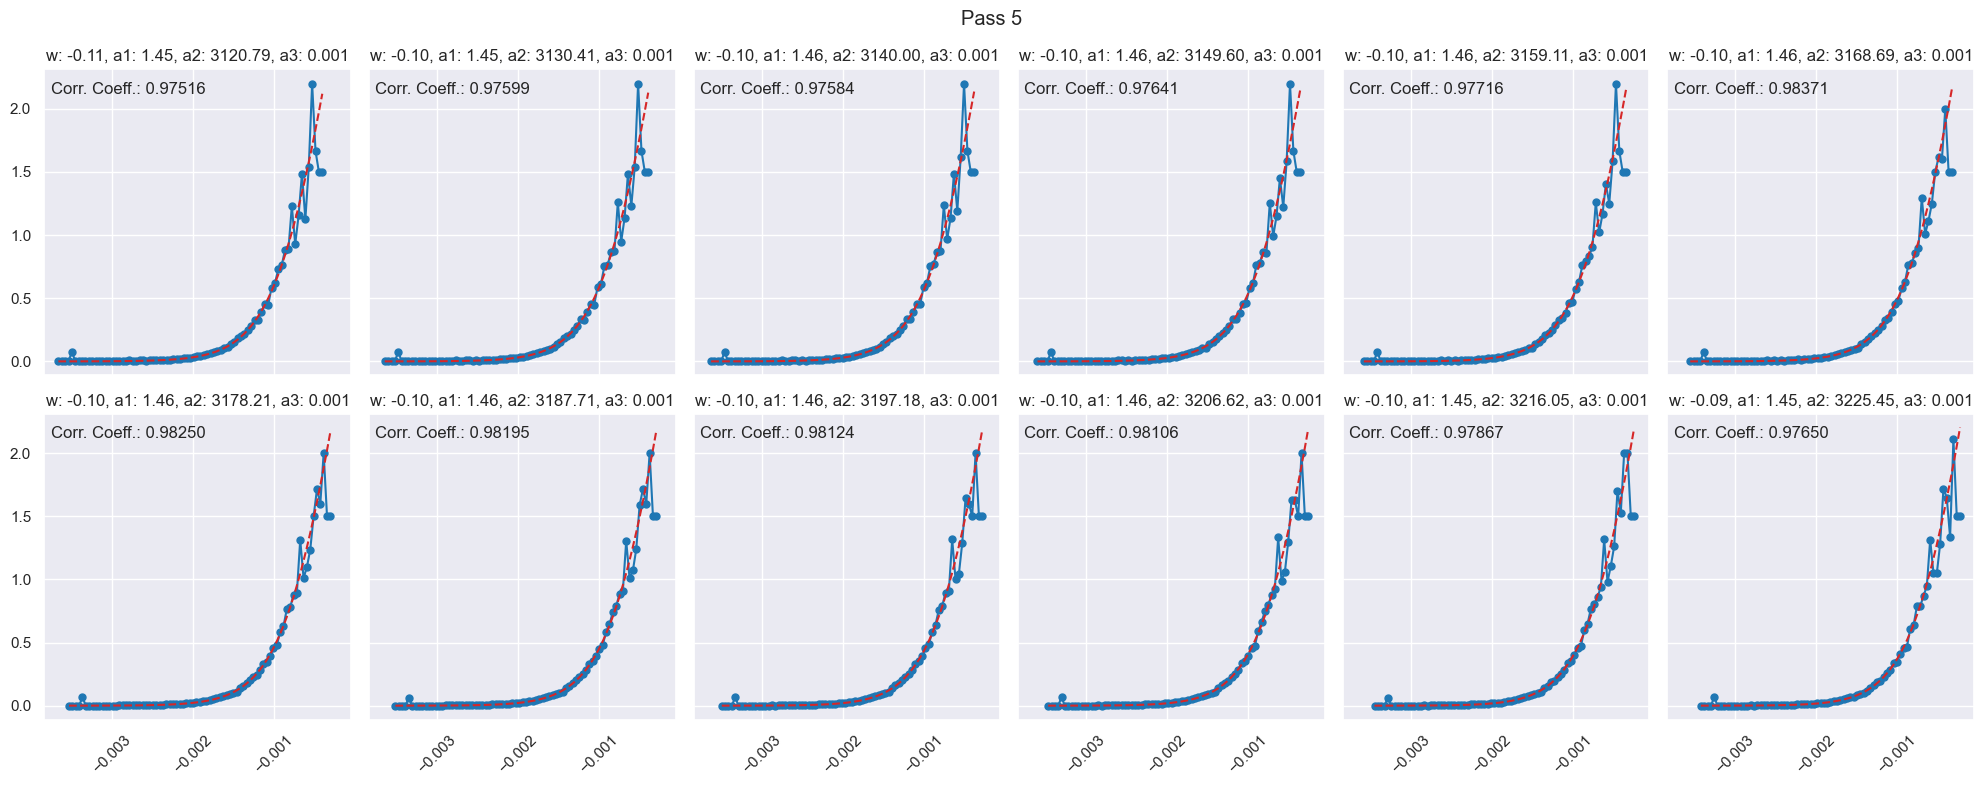

In [133]:
selected_w, selected_params = fit_parameters(i_mean, lsc, num_bins, cell_response, kernel_size, softmax_model,
                                             init_ws=(-50, 51, 10), p0=(4.0, 0.0, -0.001), fit_bounds=bounds, passes=5, plot=True)

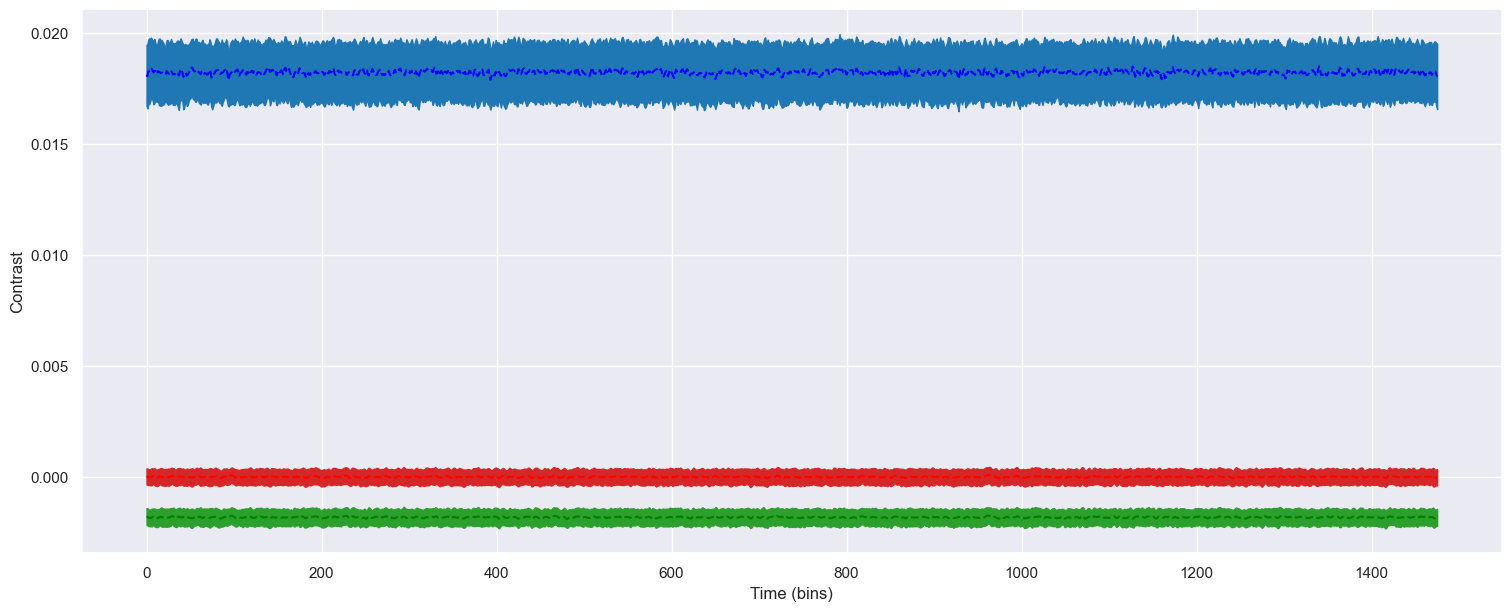

In [134]:
fig, axis = plt.subplots(figsize=(15, 6), layout="constrained")

x_axis = np.arange(i_mean.shape[-1])
i_mean_mean = i_mean.mean(axis=0)
i_mean_std = i_mean.std(axis=0)
i_mean_y1 = i_mean_mean + i_mean_std
i_mean_y2 = i_mean_mean - i_mean_std

lsc_mean = lsc.mean(axis=0)
lsc_std = lsc.std(axis=0)
lsc_y1 = lsc_mean + lsc_std
lsc_y2 = lsc_mean - lsc_std

cs = i_mean + selected_w * lsc
cs_mean = cs.mean(axis=0)
cs_std = cs.std(axis=0)
cs_y1 = cs_mean + cs_std
cs_y2 = cs_mean - cs_std

axis.fill_between(x=x_axis, y1=i_mean_y1, y2=i_mean_y2, color='tab:red')
axis.plot(x_axis, i_mean_mean, ls='--', c='red')

axis.fill_between(x=x_axis, y1=lsc_y1, y2=lsc_y2, color='tab:blue')
axis.plot(x_axis, lsc_mean, ls='--', c='blue')

axis.fill_between(x=x_axis, y1=cs_y1, y2=cs_y2, color='tab:green')
axis.plot(x_axis, cs_mean, ls='--', c='green')

axis.set_xlabel("Time (bins)")
axis.set_ylabel("Contrast")

plt.show()

### Prediction on Frozen Stimulus

In [135]:
frozen_response = frozen[cell_id]

In [136]:
print("(#trials, #bins, #height, #width)")
print(frozen_stimuli.shape)

(#trials, #bins, #height, #width)
(1, 300, 150, 200)


In [137]:
i_mean_frozen, lsc_frozen = convolve_stimulus_with_kernels_for_sc(frozen_stimuli, pred_spat_kern, temp_kern, 1, x_, y_, sta_window)

Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)


In [138]:
print(i_mean_frozen.shape, lsc_frozen.shape)

(1, 276) (1, 276)


In [139]:
f_convolved = i_mean_frozen[0] + selected_w * lsc_frozen[0]

In [140]:
print(i_mean_frozen.min(), i_mean_frozen.max())
print(lsc_frozen.min(), lsc_frozen.max())
print(f_convolved.min(), f_convolved.max())
print(f_convolved.mean())

-0.0010112136064884827 0.0009709535616112346
0.014878369214489387 0.02227801788473501
-0.00315417139601758 -0.0008210973677827073
-0.0018432548455211493


In [141]:
predicted = softmax_model(f_convolved, *selected_params)

In [142]:
print(predicted.shape)

(276,)


In [143]:
calculated = np.mean(frozen_response, axis=0)[kernel_size - 1:]

In [144]:
calculated.shape

(276,)

In [145]:
r, p = pearsonr(calculated, predicted)

In [146]:
xlist = np.arange(kernel_size - 1, frozen_stimuli.shape[1])

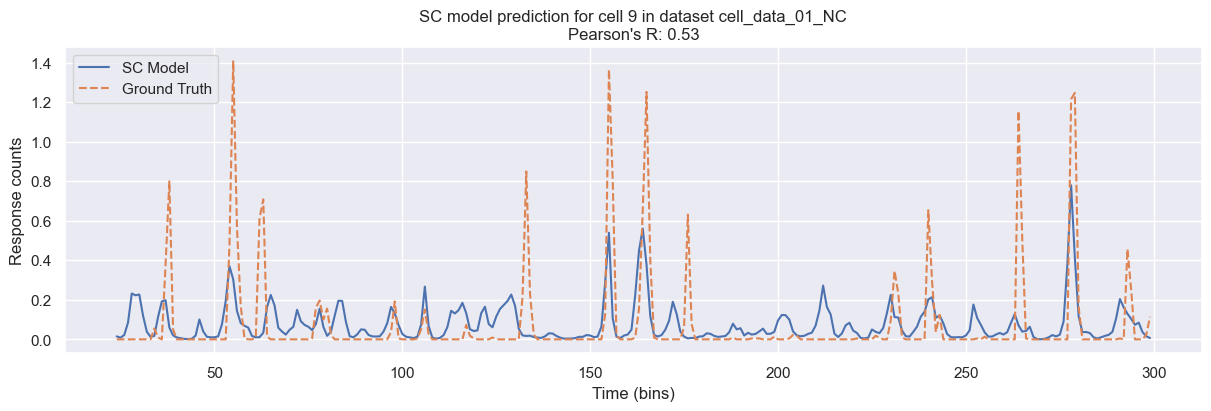

In [147]:
fig, ax = plt.subplots(figsize=(12, 4), constrained_layout=True)
p1, = ax.plot(xlist, predicted, label="SC Model")
p2, = ax.plot(xlist, calculated, ls='--', label="Ground Truth")

ax.set_xlabel("Time (bins)")
ax.set_ylabel("Response counts")
ax.set_title(f"SC model prediction for cell {cell_id} in dataset {dataset}\nPearson's R: {r:.2f}")
ax.legend(handles=[p1, p2])
ax.grid(True)
plt.savefig(f"./prediction_plots/{dataset}/sc_model/frozen_corr/{cell_id}.png")
plt.show()

In [148]:
bounds = ([0.0, 0.0, -1.0],
          [2000.0, 20000.0, 1.0])
num_bins = 80

In [149]:
for cell_id in tqdm(range(frozen.shape[0]), total=frozen.shape[0], desc="Cells"):
    cell_response = running[cell_id]
    frozen_response = frozen[cell_id]
    cell_sta = stas[cell_id]
    cell_mis_pos = mis_pos_list[cell_id]
    t_, y_, x_ = cell_mis_pos
    spat_kern, temp_kern = get_spat_temp_kern(cell_sta, cell_mis_pos, sta_window)
    gauss_params, pred_spat_kern = fit_gauss2d(spat_kern, sta_window)

    i_mean, lsc = convolve_stimulus_with_kernels_for_sc(stimuli, pred_spat_kern, temp_kern, running.shape[1], x_, y_, sta_window)

    selected_w, selected_params = fit_parameters(i_mean, lsc, num_bins, cell_response, kernel_size, softmax_model,
                                                 init_ws=(-50, 51, 10), p0=(4.0, 0.0, -0.001), fit_bounds=bounds, passes=4, plot=False)

    i_mean_frozen, lsc_frozen = convolve_stimulus_with_kernels_for_sc(frozen_stimuli, pred_spat_kern, temp_kern, 1, x_, y_, sta_window)

    f_convolved = i_mean_frozen[0] + selected_w * lsc_frozen[0]

    predicted = softmax_model(f_convolved, *selected_params)

    calculated = np.mean(frozen_response, axis=0)[kernel_size - 1:]

    r, p = pearsonr(calculated, predicted)

    xlist = np.arange(kernel_size - 1, frozen_stimuli.shape[1])

    fig, ax = plt.subplots(figsize=(12, 4), constrained_layout=True)
    p1, = ax.plot(xlist, predicted, label="SC Model")
    p2, = ax.plot(xlist, calculated, ls='--', label="Ground Truth")

    ax.set_xlabel("Time (bins)")
    ax.set_ylabel("Response counts")
    ax.set_title(f"SC model prediction for cell {cell_id} in dataset {dataset}\nPearson's R: {r:.2f}")
    ax.legend(handles=[p1, p2])
    ax.grid(True)
    plt.savefig(f"./prediction_plots/{dataset}/sc_model/frozen_corr/{cell_id}.png")
    plt.close()

Cells:   0%|          | 0/78 [00:00<?, ?it/s]

Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)
Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (300, 1500, 150, 200)


/tmp/ipykernel_380850/4255744870.py:137: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Temporal kernel: (25,)
Spatial kernel: (2500,)
Stimulus: (1, 300, 150, 200)


## All Cells

In [156]:
results = sc_model(
    running_stimuli=stimuli,
    frozen_stimuli=frozen_stimuli,
    running_responses=running,
    frozen_responses=frozen,
    stas=stas,
    kernel_size=kernel_size,
    sta_window=sta_window,
    fit_func=softmax_model,
    fit_bounds=bounds,
    fit_bins=num_bins,
)

# results_df = pd.read_pickle(f"./prediction_plots/{dataset}/sc_model/results.pkl")

Cell:   0%|          | 0/78 [00:00<?, ?it/s]

/tmp/ipykernel_380850/388906630.py:134: RuntimeWarning: overflow encountered in exp
  return a1 * np.log(1 + np.exp(a2 * (x + a3)))


Least sq. optimization failed for w=-2.0... skipping it!


In [157]:
results_df = pd.DataFrame(results)

In [167]:
results_df

,cell_id,w,ln_fit_params,r_value,gauss_fit_params
0,0,-1.110223e-16,"[1.3778575234709416, 3388.3546304144716, -0.00...",0.298080,"[12.521706231783062, 21.890808574637866, 23.35..."
1,1,-1.110223e-16,"[63.48112007641833, 11248.448468795403, -0.000...",0.475498,"[1.0948835676759014, 27.515987099071943, 27.03..."
2,2,-1.000000e-01,"[0.06536192747225764, 3974.8863111536593, 0.00...",0.249957,"[8.906458088120413, 26.148113084566287, 23.915..."
3,3,-1.110223e-16,"[0.8145841649474231, 4718.247498139006, -0.000...",0.104750,"[8.125213799245904, 26.229558007176635, 24.280..."
4,4,1.000000e-01,"[0.5056310970513124, 3130.6861660321683, -0.00...",0.489019,"[6.76052265589657, 25.422501360211708, 24.7596..."
...,...,...,...,...,...
73,73,-1.000000e-01,"[4.240041240516953, 3369.859763450876, -7.3071...",0.100606,"[8.183795173560151, 24.059474745503415, 25.467..."
74,74,1.000000e-01,"[0.7059373854810973, 2880.6945406459586, -0.00...",0.424957,"[10.39449094853674, 27.19749567338734, 25.4628..."
75,75,-1.000000e-01,"[48.6965613659399, 3677.5564027880137, -0.0008...",0.404412,"[7.45712144340674, 23.662000395252765, 25.3113..."
76,76,-1.110223e-16,"[490.3663347019853, 3187.432725926987, -0.0031...",0.391278,"[8.927633863331849, 21.705777849662805, 23.459..."


In [158]:
save_all_gauss_fit_plots(sta_array=stas, output_df=results_df, sta_window=sta_window, save_folder=f"./prediction_plots/{dataset}/sc_model/sta_fit/")

Cells:   0%|          | 0/78 [00:00<?, ?it/s]

In [159]:
results_df.to_pickle(f"./prediction_plots/{dataset}/sc_model/results.pkl")

In [160]:
print(f"Mean r_value is {results_df.r_value.mean()}")

Mean r_value is 0.32301576877906724


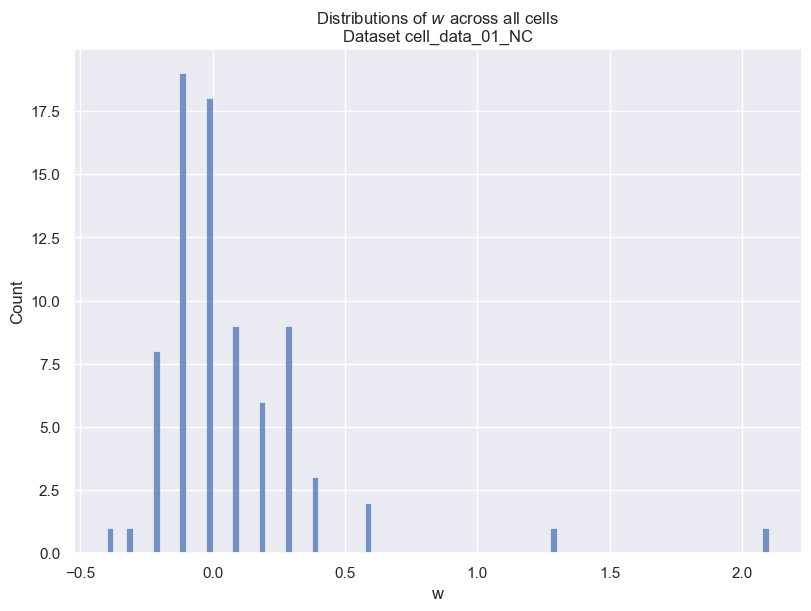

In [163]:
fig, axis = plt.subplots(figsize=(8, 6), layout="constrained")
plot = sns.histplot(results_df["w"], bins=100, ax=axis)
plot.set_title(f"Distributions of $w$ across all cells\nDataset {dataset}")
plt.savefig(f"./prediction_plots/{dataset}/sc_model/w_value_dist.png")
plt.show()

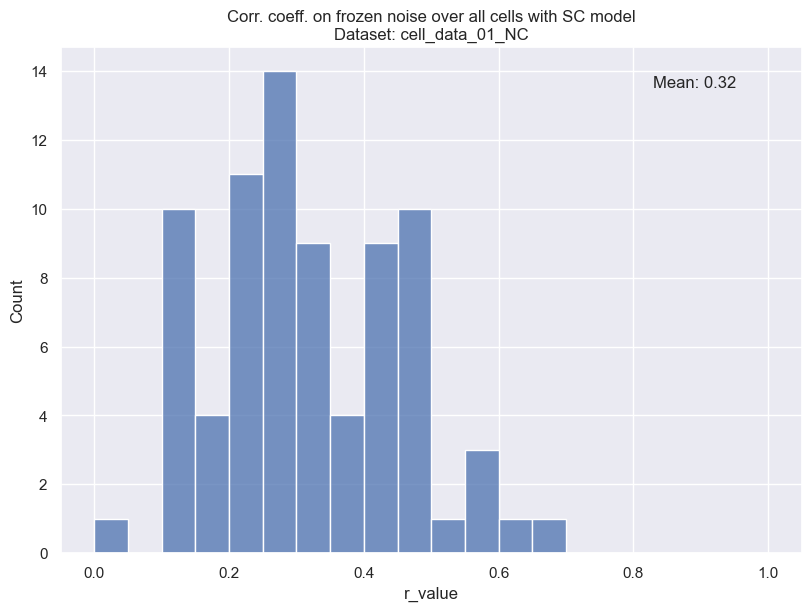

In [164]:
fig, axis = plt.subplots(figsize=(8, 6), layout="constrained")
plot = sns.histplot(results_df["r_value"], binrange=(0.0, 1.0), bins=20, ax=axis)
plot.set_title(f"Corr. coeff. on frozen noise over all cells with SC model\nDataset: {dataset}")
plot.text(0.8, 0.92, f"Mean: {results_df.r_value.mean():.2f}", transform=plot.transAxes)
plt.savefig(f"./prediction_plots/{dataset}/sc_model/r_value_dist.png")
plt.show()

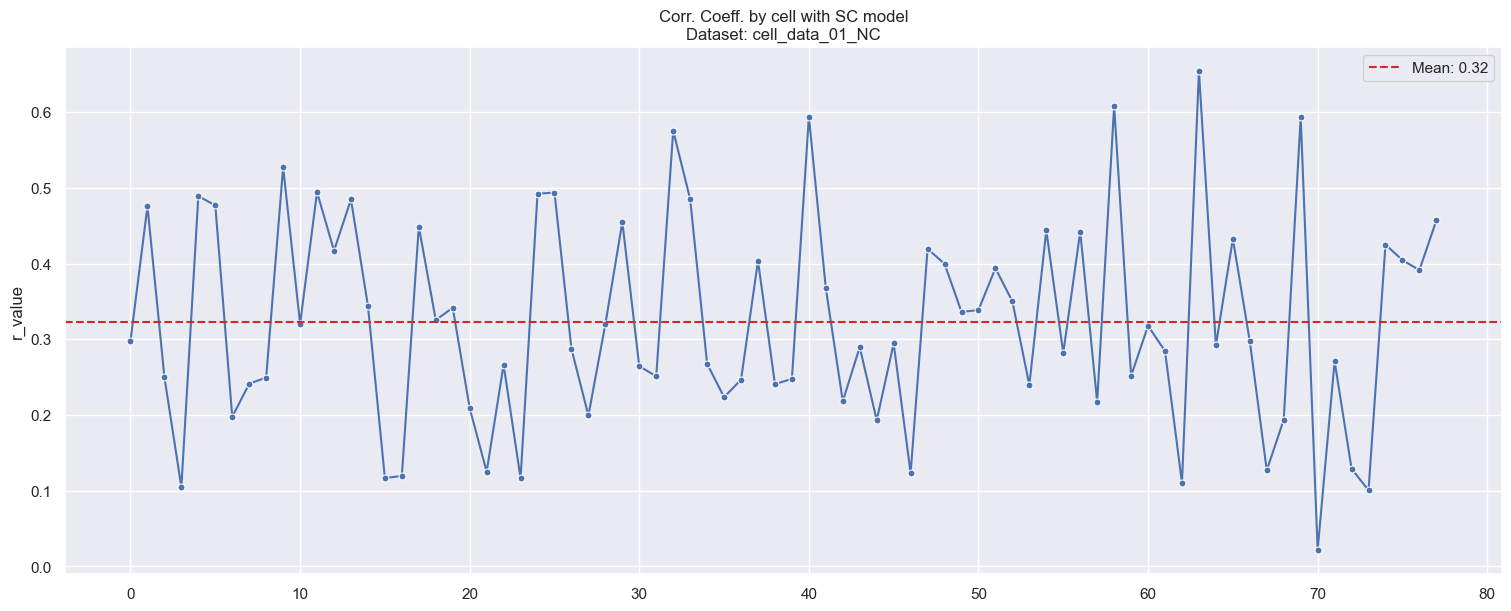

In [166]:
fig, axis = plt.subplots(figsize=(15, 6), layout="constrained")
plot = sns.lineplot(x=np.arange(results_df.shape[0]), y=results_df.r_value, marker='o', ms=5, ax=axis)
plot.set_title(f"Corr. Coeff. by cell with SC model\nDataset: {dataset}")
mean = results_df.r_value.mean()
plot.axhline(mean, ls='--', c='tab:red', label=f"Mean: {mean:.2f}")
plt.legend()
plt.show()

In [168]:
ln_res_df = pd.read_pickle(f"./prediction_plots/{dataset}/ln_model/without_gauss/results.pkl")
ln_g_res_df = pd.read_pickle(f"./prediction_plots/{dataset}/ln_model/with_gauss/results.pkl")

In [170]:
comp_r_df = pd.DataFrame({"sc_model": results_df.r_value, "ln_model": ln_res_df.r_value, "ln_gauss_model": ln_g_res_df.r_value})

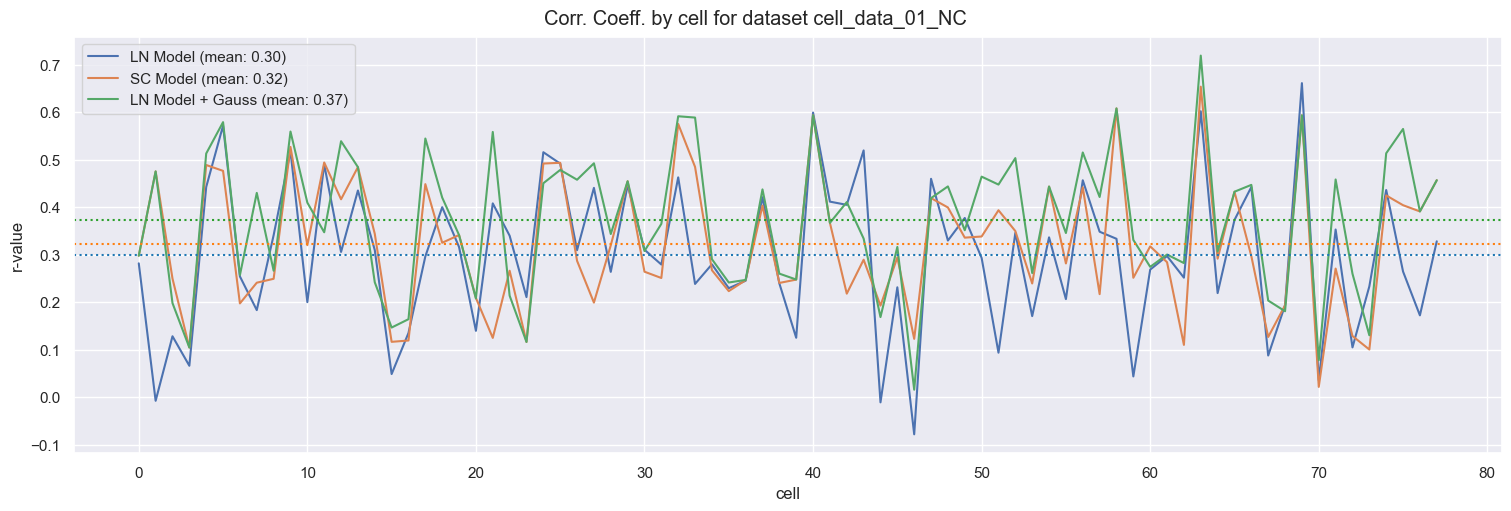

In [196]:
fig, ax = plt.subplots(figsize=(15, 5), layout="constrained")
ax.plot(comp_r_df.ln_model, label=f"LN Model (mean: {comp_r_df.ln_model.mean():.2f})")
ax.plot(comp_r_df.sc_model, label=f"SC Model (mean: {comp_r_df.sc_model.mean():.2f})")
ax.plot(comp_r_df.ln_gauss_model, label=f"LN Model + Gauss (mean: {comp_r_df.ln_gauss_model.mean():.2f})")
ax.axhline(y=comp_r_df.ln_model.mean(), ls=':', color="tab:blue")
ax.axhline(y=comp_r_df.sc_model.mean(), ls=':', color="tab:orange")
ax.axhline(y=comp_r_df.ln_gauss_model.mean(), ls=':', color="tab:green")
ax.set_xlabel("cell")
ax.set_ylabel("r-value")
fig.suptitle(f"Corr. Coeff. by cell for dataset {dataset}")
plt.legend()
plt.savefig(f"./prediction_plots/{dataset}/ln_lng_sc_by_cell.png", dpi=300, bbox_inches="tight")
plt.show()

In [197]:
wide_comp_r_df = pd.melt(comp_r_df, value_vars=["ln_model", "sc_model", "ln_gauss_model"], var_name="model", value_name="r_value")

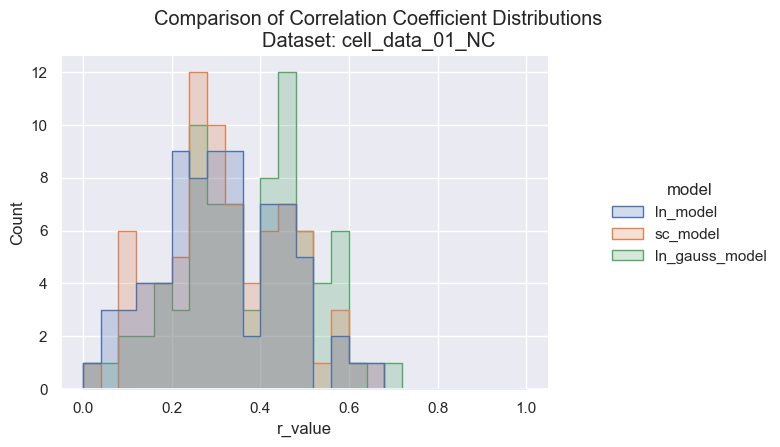

In [210]:
f = sns.displot(wide_comp_r_df, x="r_value", hue="model", element="step", fill=True, binrange=(0, 1), bins=25)
f.figure.set(size_inches=(8, 4))
f.figure.suptitle(f"Comparison of Correlation Coefficient Distributions\nDataset: {dataset}", y=1.08)
plt.savefig(f"./prediction_plots/{dataset}/compare_ln_sc_r_values.png", bbox_inches='tight', dpi=300)
plt.show()